In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
CAPTCHA_IMAGE_FOLDER = "generated_captcha_images"
OUTPUT_FOLDER = "extracted_letter_images"

In [2]:
def generate_data():
    char_folders=os.listdir(OUTPUT_FOLDER)
    images=[]
    labels=[]
    for folder in char_folders:
        if(folder.startswith('.')):
            continue
        char_path=os.listdir(OUTPUT_FOLDER+'/'+folder)
        for imag in char_path:
            img=cv2.imread(OUTPUT_FOLDER+'/'+folder+'/'+imag,0)
            img=cv2.resize(img,(20,20))
            #img = (img-img.mean())/img.std()
            img = img.reshape((20,20,1))
            images.append(img)
            labels.append(folder)
    print(len(images))
    print(len(labels))
    return images,labels

In [3]:
xtrain,ytrain=generate_data()

37896
37896


In [4]:
ytrain[0]

'R'

In [5]:
from sklearn.preprocessing import LabelBinarizer
lb=LabelBinarizer()
lb.fit(ytrain)
print(ytrain[0])
print(lb.classes_)
ytrain=lb.transform(ytrain)
print(ytrain[0])
print(ytrain.shape)
# labels=lb.inverse_transform(labels)

R
['2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'J' 'K'
 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
(37896, 32)


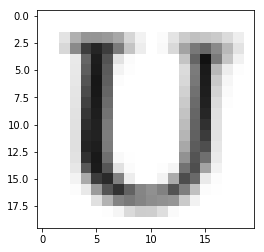

In [6]:
xtrain_np=np.array(xtrain,dtype=float)/255.0
plt.imshow(cv2.cvtColor(xtrain[1933].reshape(20,20), cv2.COLOR_BGR2RGB))

In [7]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,Ytrain,Yval=train_test_split(xtrain_np,ytrain,test_size=0.1)

In [8]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten

Using TensorFlow backend.


In [9]:
model=Sequential()
model.add(Conv2D(128,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(20,20,1)))
model.add(MaxPooling2D(pool_size=2,padding='Same'))
model.add(Conv2D(64,kernel_size=4,strides=1,padding='Same',activation='relu'))
model.add(MaxPooling2D(pool_size=2,padding='Same'))
model.add(Flatten())
model.add(Dense(32,activation='sigmoid'))
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 128)       3328      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        131136    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                51232     
Total params: 185,696
Trainable params: 185,696
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.fit(Xtrain,Ytrain,validation_data=(Xval,Yval),batch_size=64,epochs=5)

Train on 34106 samples, validate on 3790 samples
Epoch 1/5
34106/34106 [==============================] - 102s 3ms/step - loss: 0.3037 - acc: 0.9243 - val_loss: 0.0374 - val_acc: 0.9937
Epoch 2/5
34106/34106 [==============================] - 134s 4ms/step - loss: 0.0149 - acc: 0.9970 - val_loss: 0.0323 - val_acc: 0.9921
Epoch 3/5
34106/34106 [==============================] - 66s 2ms/step - loss: 0.0060 - acc: 0.9986 - val_loss: 0.0221 - val_acc: 0.9963
Epoch 4/5
34106/34106 [==============================] - 68s 2ms/step - loss: 0.0030 - acc: 0.9991 - val_loss: 0.0171 - val_acc: 0.9979
Epoch 5/5
34106/34106 [==============================] - 69s 2ms/step - loss: 0.0033 - acc: 0.9993 - val_loss: 0.0248 - val_acc: 0.9971


In [11]:
model.evaluate(Xtrain,Ytrain)

34106/34106 [==============================] - 20s 597us/step


[0.002699505389853501, 0.9994429132703923]

In [52]:
out=[]
def test(image_names):
    CAPTCHA_IMG_FOLDER=CAPTCHA_IMAGE_FOLDER+'/'+'train_images'
    for image in image_names:
        if(image.startswith('.')):
            continue
        im_path=CAPTCHA_IMG_FOLDER +'/'+ image
        gray=cv2.imread(im_path)
        gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
        gray = cv2.copyMakeBorder(gray, 20, 20, 20, 20, cv2.BORDER_REPLICATE)
        thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        contours= cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours=contours[0]
        im_letters=[]
        for contour in contours:
            (x,y,w,h)=cv2.boundingRect(contour)
            if w/h>1.5:
                im_letters.append((x,y,w//2,h))
                im_letters.append((x+w//2,y,w//2,h))
            else:
                im_letters.append((x,y,w,h))
        if(len(im_letters)!=4):
            continue
        im_letters=sorted(im_letters,key=lambda x : x[0])
        output = cv2.merge([gray] * 3)
        predictions = []
        for letter_box in im_letters:
            (x,y,w,h)=letter_box
            letter_img=gray[y-2:y+h+2,x-2:x+w+2]
            img=cv2.resize(letter_img,(20,20))
            img = img.reshape((1,20,20,1))
            pred=model.predict(img)
            p_letter=lb.inverse_transform(pred)[0]
            predictions.append(p_letter)
            cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (0, 255, 0), 1)
            cv2.putText(output, p_letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0, 255, 0), 2)
        capcha_test="".join(predictions)
        if(capcha_test==image.split('.')[0]):
            out.append(output)

In [53]:
test_images=os.listdir(CAPTCHA_IMAGE_FOLDER+'/'+'train_images')[0:100]
test(test_images)

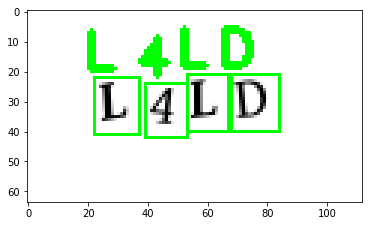

In [54]:
plt.imshow(out[0])

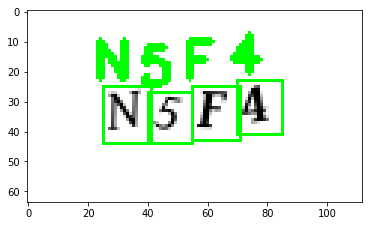

In [55]:
plt.imshow(out[1])

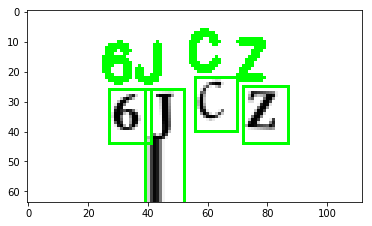

In [56]:
plt.imshow(out[2])